In [1]:
from neurotron import Attribute, Matrix, Field, Collab, Excite, Predict, Terminal, Cluster,Token
from neurotron import isa,rand,sum,zeros,ones,row,column,min,max,seed, AND, OR, NOT, all
from neurotron.cluster import Cell, Record


In [2]:
#===========================================================================
# helper: check cell's movie with given pattern
#===========================================================================

def check(cells,pattern):
    """
    check(): check recorder pattern of a network of cells against a given
             pattern and raise exception if check fails.
    >>> par,token = toy('sarah')
    >>> cells = Cells(3,par,[3,10])
    >>> y = cells.iteration([0,0,0]+token['Sarah'])
    >>> check(cells,'|U,U,QB,QBY,DY,D--|---D,XD,X,X,X|---D,D---|')
    """
    p = cells.record.pattern()
    if p != pattern:
        print('expected: ',pattern)
        print('got:      ',p)
        raise Exception('pattern check failed')



In [14]:
class Cells(Cluster):
    def __init__(self,token):
        shape = (2,9,2,5);  seed(1)
        cells = super().__init__(*shape,verbose=1)
        self.token = token
        m,n,d,s = shape
        self.y = row(zeros(1,m*n),token['Mary'])
        self.record = Record(self)

    def process(self,word,all=None):
        m,n,d,s = self.shape
        self.y = row(zeros(1,m*n),token[word])
        self.y = self.apply(self.y,word,all=all)

    def predictive(self,list):
        for k in list:
            cells.X[k] = 1;
            cells._predict.I[k] = Matrix([[.1,-.1,.1,-.1,.1],[0,0,0,0,0]])

    def __str__(self):
        self.record.clear();  
        self.record(self)
        return self.record.pattern()

    def __repr__(self):
        return self.__str__()

        
token = Token({'Mary': [1,0,0,0,0,0,0,1,1],
               'John': [0,1,0,0,0,0,0,1,1],
               'likes':[0,0,1,0,0,0,0,1,1],
               'to':   [0,0,0,1,0,0,0,1,1],
               'sing': [0,0,0,0,1,0,0,1,1],
               'dance':[0,0,0,0,0,1,0,1,1],
               '.':    [0,0,0,0,0,0,1,1,1],
               })

def setup(token):
    cells = Cells(token)
    predict = cells._predict.clear()
    
    predict.K[0,2] = Matrix([[0,14,16,12,12], [0,0,0,0,0]])
    predict.P[0,2] = Matrix([[.5,.5,.5,.4,.4], [0,0,0,0,0]])

    predict.K[0,3] = Matrix([[4,14,16,12,12], [0,0,0,0,0]])
    predict.P[0,3] = Matrix([[.5,.5,.5,.4,.4], [0,0,0,0,0]])

    predict.K[0,4] = Matrix([[6,14,16,12,12], [0,0,0,0,0]])
    predict.P[0,4] = Matrix([[.5,.5,.5,.4,.4], [0,0,0,0,0]])
    return cells

cells = setup(token)


mind I[4]: [0.1 0.1 0.1 -0.1 -0.1; 0 0 0 0 0]


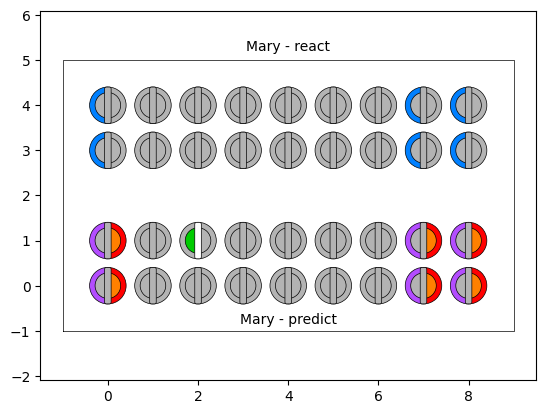

In [15]:
cells.process('Mary')
#check(cells,'|UQBY|UQBY|-|-|XS|-|-|-|-|-|-|-|-|-|UQBY|UQBY|UQBY|UQBY|')

learn P[4]: [0.6 0.6 0.6 0.3 0.3; 0 0 0 0 0] by [0.1 0.1 0.1 -0.1 -0.1; 0 0 0 0 0]
mind I[6]: [0.1 0.1 0.1 -0.1 -0.1; 0 0 0 0 0]


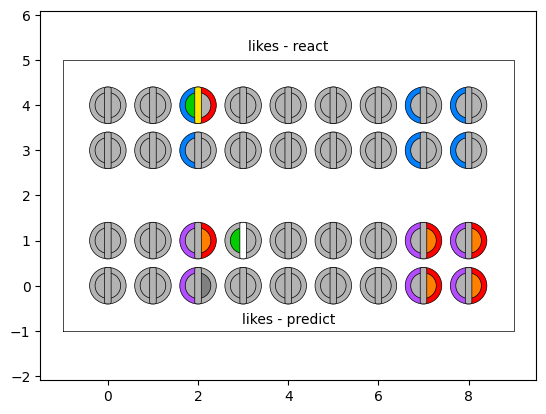

In [16]:
cells.process('likes')

learn P[6]: [0.6 0.6 0.6 0.3 0.3; 0 0 0 0 0] by [0.1 0.1 0.1 -0.1 -0.1; 0 0 0 0 0]
mind I[8]: [0.1 0.1 0.1 -0.1 -0.1; 0 0 0 0 0]


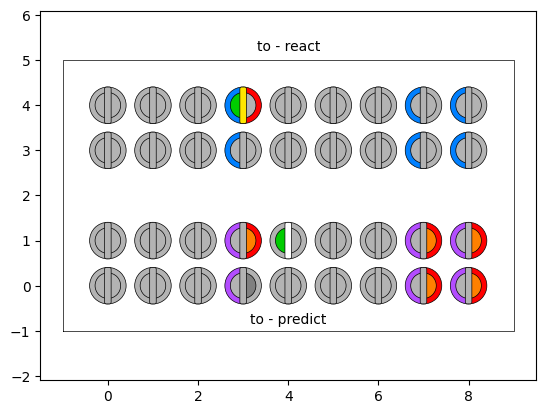

In [17]:
cells.process('to')

learn P[8]: [0.6 0.6 0.6 0.3 0.3; 0 0 0 0 0] by [0.1 0.1 0.1 -0.1 -0.1; 0 0 0 0 0]


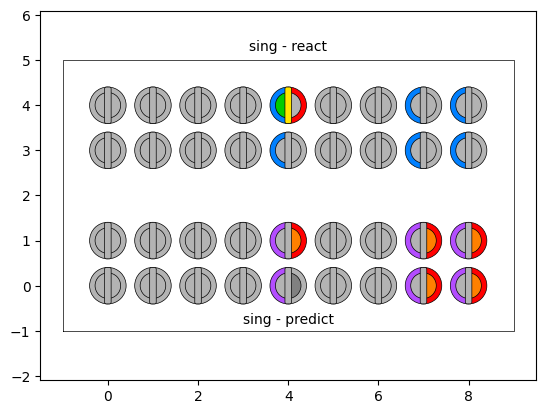

In [18]:
cells.process('sing')